<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Practice day #2: ES models

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 

This practice task is desinged for impriving knowledge of ARIMA models and getting aqcuainted with statistical time series analysis in python.

The task should take about 3-5 hours to be completed.

<h1 align="center">1. Reading data (5%)</h1>

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)
     - 2) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_cunsumption.csv</span> (105 TS of goods sales in shop #36 of one real Retail Net, each TS correspond to an item in shop )
 
 All data you can find by <a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ5by4qa_HFqAAoYIg'>link</a> 
 
 
 * For each data set: 
      - 1) learn it's structure in csv-file and read it into Pandas data frame (be careful with parsing data)
      - 2) plot each time series
      - 3) answer the questions: is there seasonlaity, trend, changes in level in TS? If there is seasonality then define period of seasonality. 

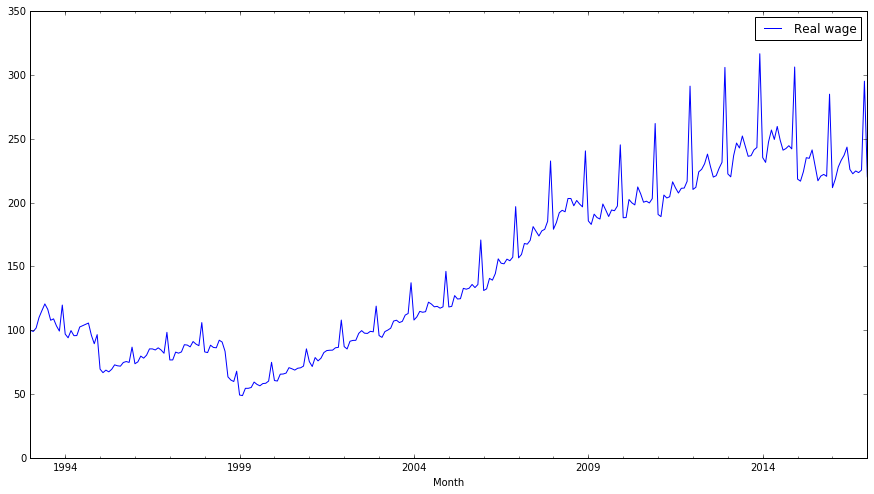

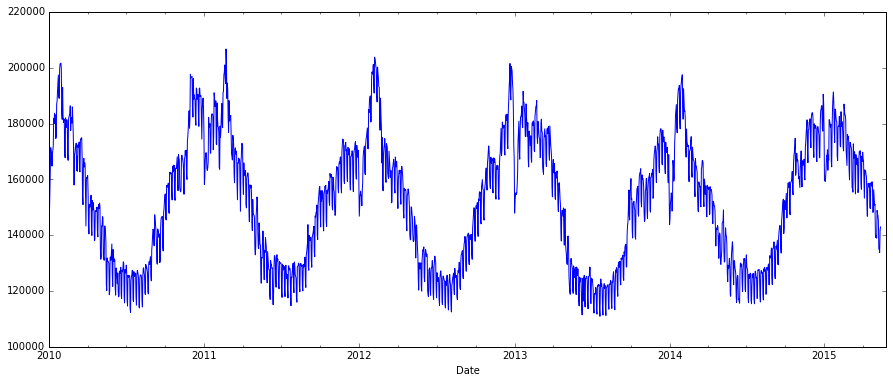

,Real wage
Month,
1993-01-01,100.00
1993-02-01,99.04
1993-03-01,101.77
1993-04-01,110.05
1993-05-01,115.47


In [156]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm

import warnings as w
import plotly.plotly as py
from IPython.display import Image

%matplotlib inline

ts_wage = pd.read_csv("/home/vachik/Machine_Learning/TS/Practical/Practical1/monthly-wage.csv", sep=';', decimal='.', index_col= 'Month', parse_dates=True, dayfirst=True)
ts_wage.plot(figsize=(15,8))
plt.show()
ts_energy =pd.read_csv("/home/vachik/Machine_Learning/TS/Practical/Practical2/energy_consump.csv", sep=',', decimal='.', index_col ="Date", parse_dates=True, dayfirst=True)
ts_energy["EnergyConsump"].plot( figsize=(15,6))
plt.show()
ts_wage.head(5)

<h1 align="center">2. ARIMA Momdel for wage dataset (40%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters your self ** 
Also you can follow the next scheme:
<img src='./pic/ARMA Scheme.png'>


Notes: you need follow to the steps
 * 0) Use data before 01.02.2015 
 * 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
 * 2) Dispersion is stabilized through transformation if needed.
 * 3) If the time series is non-stationary the differentiation degrees is
chosen.
 * 4) ACF/PACF are analyzed in order to understand whether AR(p)/MA(q) and seasonal $AR(P)/MA(Q)$  may be used.
 * 5) Candidate models are trained, their AIC/AIC is compared, choose trhe best model.
 * 6) Unbiasedness, stationarity and non-autocorrelation of the residuals of the obtained model are tested; if the tests fail model modifcations are reviewed.
 * 7) Build forecasts and forecastis interval for period from 01.02.2015 to 01.01.2017
     Calculate loss MACAPE of your Forecast.
     Does the forecast look like appropriate?

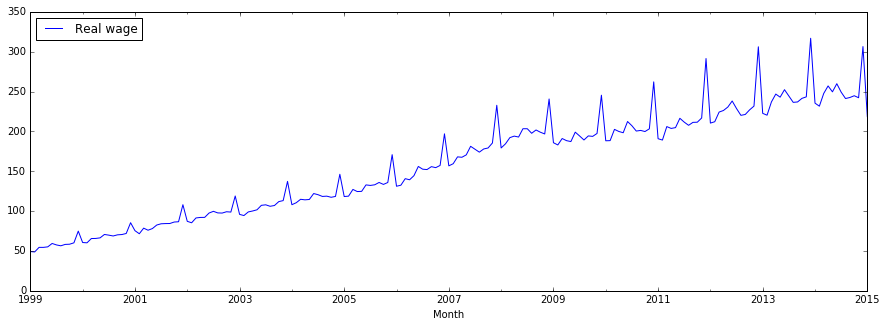

In [157]:
ts_wage = ts_wage.ix['01.01.1999':'01.01.2015']
ts_wage.plot(figsize=(15,5))

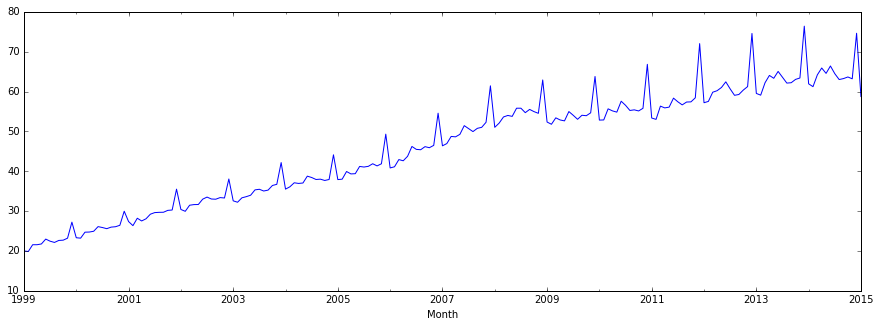

In [158]:
from copy import deepcopy
ts_wage_boxcox = deepcopy(ts_wage)
ts_wage_boxcox['wage_boxcox'] = stats.boxcox(ts_wage)[0]
ts_wage_boxcox['wage_boxcox'].plot(figsize=(15,5))


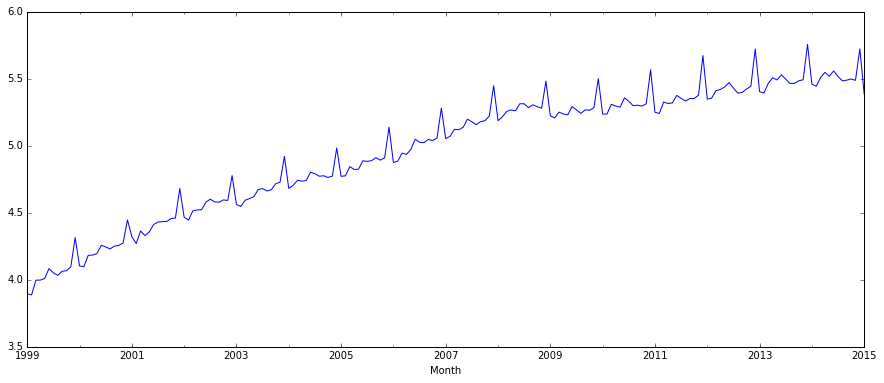

In [159]:

ts_wage_boxcox['wage_boxcox'] = np.log(ts_wage)
ts_wage_boxcox['wage_boxcox'].plot(figsize=(15,6))

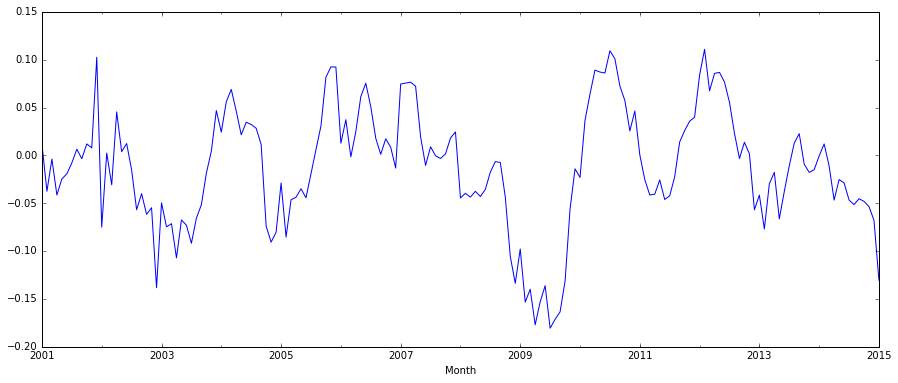

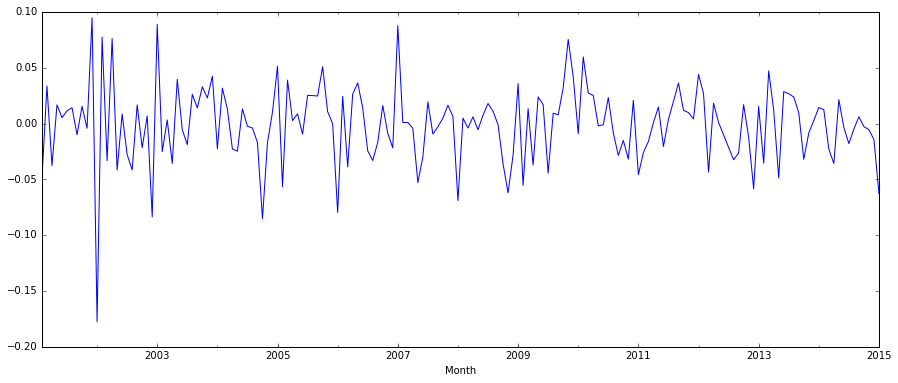

In [200]:
p = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox - sdiff_ts_wage_boxcox.shift(p))[p:]
sdiff_ts_wage_boxcox.plot(figsize=(15,6))

plt.show()
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox.plot(figsize=(15,6))
plt.show()

In [201]:
from statsmodels.tsa import stattools
stat= stattools.kpss(np.array(diff_sdiff_ts_wage_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.071527, 
pvalue: 0.10 
maximal Lag: 14 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/home/vachik/anaconda3/lib/python3.5/site-packages/statsmodels-0.8.0-py3.5-linux-x86_64.egg/statsmodels/tsa/stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



In [202]:
len(diff_sdiff_ts_wage_boxcox)

168

### ACF PACF

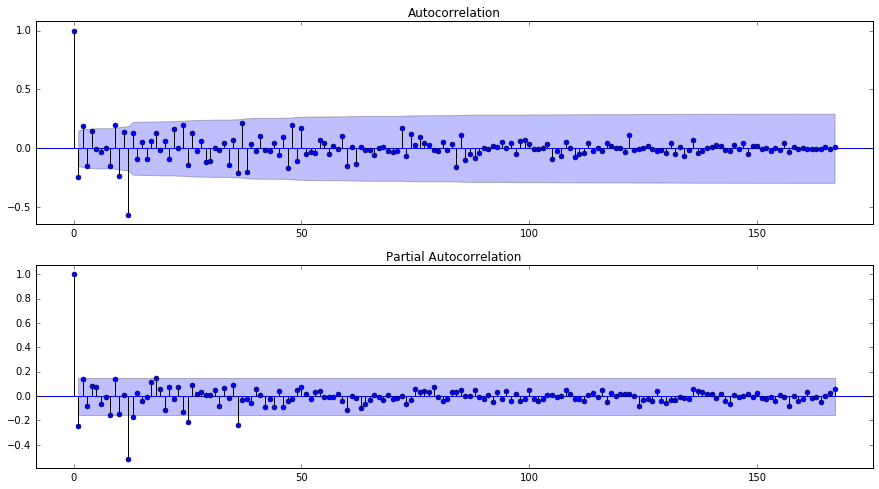

In [203]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_wage_boxcox.values.squeeze(), lags=167, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_sdiff_ts_wage_boxcox.values.squeeze(), lags=167, ax=ax2)

In [221]:
#model = sm.tsa.statespace.SARIMAX(diff_sdiff_ts_wage_boxcox, trend='n', order=(3,0,2), seasonal_order=(4,0,2,12))
#results = model.fit()

In [231]:
model = sm.tsa.statespace.SARIMAX(ts_wage, trend='n', order=(1,1,), seasonal_order=(0,1,1,12))
results = model.fit()

/home/vachik/anaconda3/lib/python3.5/site-packages/statsmodels-0.8.0-py3.5-linux-x86_64.egg/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



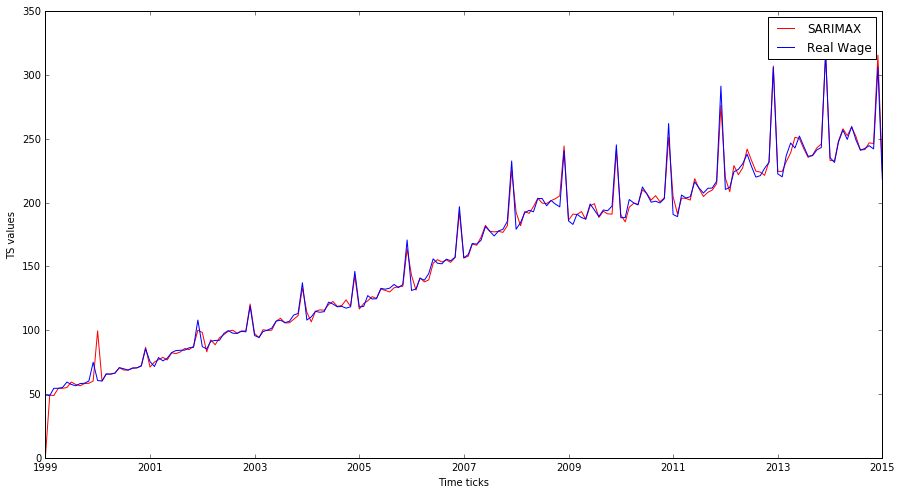

In [258]:
mod_pred = results.get_prediction()
x_pred = mod_pred.predicted_mean
plt.figure(figsize=(15,8))
plt.plot(x_pred,"r",label='SARIMAX')
plt.plot(ts_wage,'b',label='Real Wage')
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()
plt.show()

In [205]:
arma_mod01 = sm.tsa.ARMA(diff_sdiff_ts_wage_boxcox, (0,1)).fit()
print(arma_mod01.params)
print(arma_mod01.aic, arma_mod01.bic, arma_mod01.hqic)

const               -0.000722
ma.L1.wage_boxcox   -0.195140
dtype: float64
-651.1014673006438 -641.729575362 -647.297897175


/home/vachik/anaconda3/lib/python3.5/site-packages/statsmodels-0.8.0-py3.5-linux-x86_64.egg/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



**II. Find the best parameters of ARIMA automaticaly** 
* 0) Use data before 01.02.2015 
* 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
* 2) Run grid search for ARIMA parameters (at least for 3 distinct values for $p,q,d, P, Q, D$). 
How many time does it take?
* 4) Find the best set of parameters according to AIC.
* 5) Build the forecast of the best model and it's forecasting interval for period from 01.02.2015 to 01.01.2017.
* 6) Calculate locc MACAPE of your forecast.

<h1 align="center">3. ARIMA Momdel for wage dataset (55%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_consumption.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters yourself **
Follow to the steps from 2.I. 

**II. Find the best parameters of ARIMA automaticaly**

** III. Adding of exogenious variables**

* 1) Try to add in models from 3.I. and 3.II exogenious variables (at least one of Temp1, Temp2, Saturday and Sunday).
* 2) Does it make accuracy of foreacast for period from 01.02.2015 to 01.01.2017 better?